<a href="https://colab.research.google.com/github/munich-ml/MLPy2021/blob/main/31_fMNIST_classifier_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

## References
Resources used to create this notebook:
- [scikit-learn website](https://scikit-learn.org)
- [Matplotlib website](https://matplotlib.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)
- Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow, Aurelien Geron, [Book on Amazon](https://www.amazon.de/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_3?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=Hands-on+Machine+Learning+with+Scikit-learn%2C+Keras+%26+TensorFlow%2C+Aurelien+Geron%2C&qid=1589875241&sr=8-3)
- Introduction to Machine Learning with Python, Andreas Mueller, [Book on Amazon](https://www.amazon.de/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)


## Setup

First, do the common imports.

Tensorflow must be 2.x, because there are major changes from 1.x

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import os
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Setup matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

in_colab = 'google.colab' in sys.modules   # check if note is executed within Colab

# Forces tensorflow version (only in colab)
if in_colab:
    %tensorflow_version 2.x           

# Clone the repository if executed in Google Colab
if in_colab:  
    if "MLPy2021" in os.listdir():
        !git -C MLPy2021 pull
    else:
        !git clone https://github.com/munich-ml/MLPy2021/

# lib.helper_funcs.py. The import path depends on Colab or local execution 
if in_colab:
    from MLPy2021.lib.helper_funcs import pickle_out
else: 
    from lib.helper_funcs import pickle_out


Cloning into 'MLPy2021'...
remote: Enumerating objects: 365, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 365 (delta 192), reused 113 (delta 34), pack-reused 0
Receiving objects: 100% (365/365), 13.72 MiB | 17.88 MiB/s, done.
Resolving deltas: 100% (192/192), done.


# Get the data

**MNIST** is probably **THE classical dataset for image recognition**. 

A more challanging dataset is the **[fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)** from Zalando.

``tf.keras`` already includes [fashion MNIST](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) and some other popular datasets in `keras.datasets`. 

The fashion MNIST dataset is already split into a training set and a test set, but it can be useful to split the training set further to have a validation set:


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


From the [dataset documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) we know, that the **labels** are **class IDs** that correspond to the following **`class_names`**:

In [3]:
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
y_train_full[0]

9

In [5]:
class_names[y_train_full[0]]

'Ankle boot'

Plot part of the dataset to get an overview


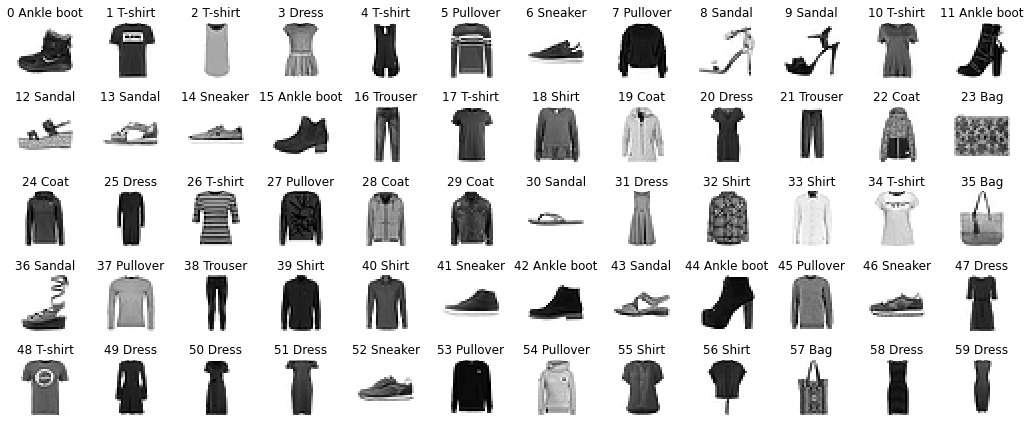

In [6]:
# code for viewing, not for teaching
n_rows, n_cols = 5, 12
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train_full[index], cmap=plt.cm.binary, interpolation="nearest")
        plt.title("{} {}".format(index, class_names[y_train_full[index]]), fontsize=12)
        plt.axis('off')
plt.tight_layout()

##Inpect the data


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [7]:
X_train_full.shape

(60000, 28, 28)

In [8]:
sample_img = X_train_full[100, :, :]
sample_img.shape

(28, 28)

One may plot an image using Matplotlib's `imshow()` function::

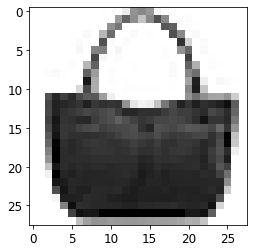

In [9]:
plt.imshow(sample_img, cmap=plt.cm.binary);

Each pixel intensity is an 8bit interger value.
- 0 is white
- 255 is black

In [10]:
sample_img.dtype

dtype('uint8')

In [11]:
pd.Series(sample_img.flatten()).value_counts().sort_index()

0      300
1       17
2       12
3        2
4        6
      ... 
240      1
241      1
249      1
250      1
255     15
Length: 147, dtype: int64

In [12]:
sample_img[:,:13]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,  18],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  99, 155],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0, 110, 136,   0],
       [  0,   0,   0,   0,   0,   1,   0,   6,   0,  72, 147,   0,   0],
       [  0,   0,   0,   0,   0,   1,   5,   0,   0, 174,   4,   0,   4],
       [  0,   0,   0,   0,   0,   0,   8,   0, 125, 128,   0,   9,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 184,   9,   0,   4,   0],
       [  0,   0,   0,   1,   0,   2,   0,  73, 158,   0,   0,   0,   0],
       [  0,   0,   2,   5,   1,   0,   0, 157,  98,   0,   2,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 231,  84,   0,   2,   1,   1],
       [  0,   0,   0,   0,   0,   0,  38, 183,  81,   0,   0,   0,   2],
       [  0,   0, 173, 216, 193, 213, 183, 164, 167,  98,  16,   0,   0],
       [  0,   0, 185, 221, 217, 210, 202, 222, 200, 206, 202, 204, 109],
       [  0,   0, 183, 220, 205, 200, 

## Scale the data

Since we are going to train the neural network using **Gradient Descent**, we must scale the input features. 

The ``SciKit-learn MinMaxScaler`` doesn't work for 2D-features. Therefore, let's implement a simple Max Scaler with ``SciKit-learn`` compliant interface:

In [13]:
from sklearn.base import TransformerMixin,BaseEstimator

class MaxScaler(BaseEstimator,TransformerMixin):

    def fit(self, X, y=None):
        self._scale = X.max()
        return self

    def transform(self, X):
        return X / self._scale

In [14]:
scaler = MaxScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

In [15]:
X_train_full.max(), X_test.max()

(1.0, 1.0)

##Split a validation set

Let's split the *full training set* into a *validation set* and a (smaller) *training set*. 

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                      test_size=5000)

In [17]:
X_train.shape

(55000, 28, 28)

In [18]:
X_valid.shape

(5000, 28, 28)

In [19]:
y_train.shape

(55000,)

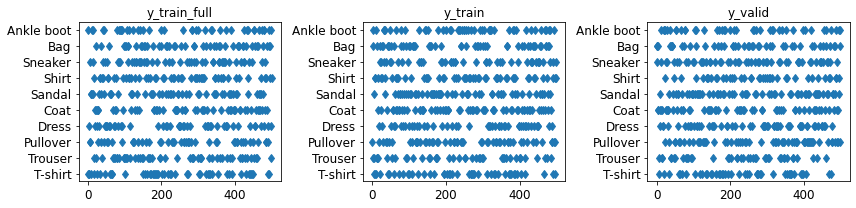

In [20]:
plt.figure(figsize=(12,3))
for i, label in enumerate(["y_train_full", "y_train", "y_valid"]):
    plt.subplot(1, 3, i+1)
    plt.plot(eval(label+"[:500]"), "d")
    plt.yticks(range(len(class_names)), labels=class_names)
    plt.title(label), plt.tight_layout();

# Build a model

The folloging  code creates a **classification MLP** (multi layer perceptron) with 2 hidden layers:

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Alternatively to using `model.add` we can pass a list of layers to the `Sequential()` constructor

In [22]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(47)

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation=keras.activations.relu),
    keras.layers.Dense(100, activation=keras.activations.relu),
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [24]:
keras.activations.relu([-2, -1, 0, 1, 2])

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 1, 2], dtype=int32)>

## Model summary

Let's print a summary of the model, using `model.summary()`


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note the huge amount of (trainable) parameters. For example, the first hidden layer has 784 * 300 connection weights, plus 300 bias terms. This gives the model quite a flexibility to fit the training data, but it's also prone to overfitting, especially with few traning data.

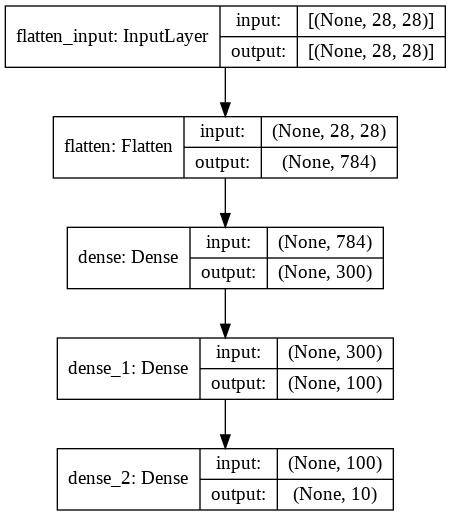

In [26]:
keras.utils.plot_model(model, show_shapes=True)

The layers of the model can be accessed with `model.layers`

In [27]:
for i, layer in enumerate(model.layers):
    print("layer {}: {}".format(i, layer.name))

layer 0: flatten
layer 1: dense
layer 2: dense_1
layer 3: dense_2


In [28]:
weights, biases = model.layers[2].get_weights()

In [29]:
weights.shape

(300, 100)

In [30]:
weights

array([[-0.08059598, -0.04436566,  0.09836388, ..., -0.00970834,
        -0.08208367, -0.08370163],
       [ 0.09863398,  0.0779072 ,  0.04579651, ...,  0.04844771,
        -0.08347219, -0.12094279],
       [ 0.03421906,  0.00415913,  0.03538304, ..., -0.02142348,
        -0.0053408 , -0.0237003 ],
       ...,
       [-0.05799503, -0.07039653,  0.04351173, ...,  0.12147508,
        -0.02084582,  0.0079603 ],
       [-0.09212115, -0.03788842, -0.00952023, ..., -0.02874079,
         0.03038765, -0.0189582 ],
       [-0.09342733,  0.03829556,  0.07831021, ..., -0.08451727,
         0.01317381, -0.06233999]], dtype=float32)

In [31]:
biases.shape

(100,)

In [32]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Note that the biases are initialized with zeros while the weights are initalized randomly. This is required to support convergence.

## Compile the model

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:
```
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

Some explanation to the `compile` params:
- The loss must be **sparse_**categorical_crossentropy because the labels are sparse, meaning just one value per training instance and not a tensor of len(10)
- The optimizer is **Stochastic Gradient Descent**, minimizing a loss function on a subset of the dataset (*stochastic approximation*)
- Since this is a **classifier**, it's useful to measure **accuracy** during training 

# Train the model

Start the training using `model.fit`

In [34]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 7s 2ms/step - loss: 0.7192 - accuracy: 0.7637 - val_loss: 0.5244 - val_accuracy: 0.8208
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4873 - accuracy: 0.8322 - val_loss: 0.4597 - val_accuracy: 0.8386
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4417 - accuracy: 0.8461 - val_loss: 0.4265 - val_accuracy: 0.8516
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4151 - accuracy: 0.8546 - val_loss: 0.4418 - val_accuracy: 0.8448
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3959 - accuracy: 0.8611 - val_loss: 0.3925 - val_accuracy: 0.8644
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3798 - accuracy: 0.8665 - val_loss: 0.4014 - val_accuracy: 0.8618
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3675 - accuracy: 0.8710 - val_loss: 0.4730 - val_accuracy:

In [35]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

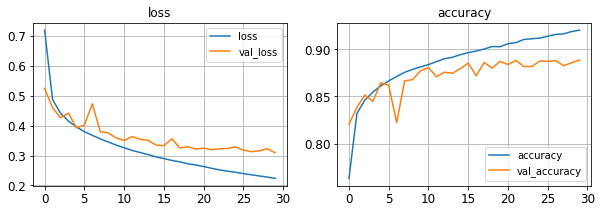

In [37]:
plt.figure(figsize=[10, 3]) 
for i, word in enumerate(["loss", "accuracy"]):
    plt.subplot(1, 2, i+1)
    for key, vals in history.history.items():
        if word in key:
            plt.plot(vals, label=key)
    plt.grid(), plt.legend(), plt.title(word)

## Mount google drive

In [38]:
mount_dir = os.path.join(os.getcwd(), "drive")
mount_dir

'/content/drive'

In [39]:
from google.colab import drive
drive.mount(mount_dir)

Mounted at /content/drive


## model.save()


In [40]:
save_dir = os.path.join(mount_dir, "My Drive", "Colab Notebooks", "models")
save_dir

'/content/drive/My Drive/Colab Notebooks/models'

In [41]:
os.path.isdir(save_dir)

True

In [42]:
fn = "fMNIST_NN_v1_ageron"
model.save(os.path.join(save_dir, fn + ".h5"))

### Save validation and test data along with the model

In [43]:
pickle_out(os.path.join(save_dir, fn+"_data.pkl"), locals(),
           X_valid, y_valid, X_test, y_test, class_names)